In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Precog

Mounted at /content/drive
/content/drive/MyDrive/Precog


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

###References

https://www.dezyre.com/student-project/toly-novik-text-mining-and-clustering-of-tweets-based-on-context/2#:~:text=Identify%20tweets%20that%20are%20talking,used%20words%20in%20each%20topic.


### Extract tweets

In [ ]:
!python3 tw.py

### Imports

In [ ]:
import pandas as pd
import numpy as np
import re

# plot
# import seaborn as sns
import matplotlib.pyplot as plt 

# Gensim for sentiment analysis
import gensim
from gensim.utils import simple_preprocess

import nltk
from nltk.corpus import stopwords, twitter_samples

from collections  import Counter
from wordcloud import WordCloud

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 


### Preprocessing


In [ ]:
df = pd.read_csv('./df.csv')

In [ ]:
df = df.dropna()
df.head()

,CreatedAt,tweets,User_ID,User_Name
0,2020-12-28 14:09:51,b'RT @TicketNew: \xf0\x9f\x9a\xa8\xf0\x9f\x94\...,1.189225e+18,Raj🅰️☮️
2,2020-12-28 14:09:50,b'@Aji_spartan \n\n@sharan14110326 \n\n@Vasant...,1.251350e+18,💘𝐉𝐞𝐧𝐢💘𝐈𝐜𝐞 𝐃𝐨𝐥𝐥♥🇱🇰
4,2020-12-28 14:09:46,"b""RT @ManokarVj: Teaser &amp; Trailer announce...",1.008243e+18,Bigil Ashok
6,2020-12-28 14:09:40,b'RT @dp_karthik09: Chances of #MasterTrailer ...,9.701324e+17,Saravana Pradeep
8,2020-12-28 14:09:29,b'RT @bussyAnandOff: #MasterTrailer Update Tod...,1.039062e+18,VIJAYAKUMAR


In [ ]:
df.rename(columns = {'Tweet': 'tweets'}, inplace=True)

In [ ]:
count = df['tweets'].str.split().str.len()
count.index = count.index.astype(str)+' words:'
print("Total number of words in the tweets =",count.sum())
print("Mean number of words per tweet :", round(count.mean(), 2))


Total number of words in the tweets = 186033
Mean number of words per tweet : 13.68


In [ ]:
print('Users: ', len(df['User_ID'].unique()))
df['tweet_length'] = df['tweets'].str.len()
print("total characters in tweets =", df['tweet_length'].sum())
print("mean number of characters per tweet =", df['tweet_length'].mean())

df = df.drop(['tweet_length'], axis=1)

Users:  3678
total characters in tweets = 2242975
mean number of characters per tweet = 164.9246323529412


In [ ]:
def remove_users(tweet, pattern1, pattern2):
        r = re.findall(pattern1, tweet)
        for i in r:
            tweet = re.sub(i, '', tweet)
        r = re.findall(pattern2, tweet)
        for i in r:
            tweet = re.sub(i, '', tweet)
        return tweet

In [ ]:
df['tidy_tweets'] = np.vectorize(remove_users)(df['tweets'],"@ [\w]*", "@[\w]*")

In [ ]:
df['tidy_tweets']=df['tidy_tweets'].str.lower()
df['tidy_tweets']=df['tidy_tweets'].apply(lambda x: x.strip('b').strip("'").strip('"').replace('\\n', '').replace("rt :", ""))

# has hashtags so removing them
df['tidy_tweets'] = np.vectorize(remove_users)(df['tidy_tweets'], "# [\w]*", "#[\w]*")

filtr = df['tidy_tweets'].str.len() != 0
df = df[filtr]

In [ ]:
def remove_links(tweet):
    tweet_no_link = re.sub(r"http\S+", "", tweet)
    return tweet_no_link

In [ ]:
# removing links

df['tidy_tweets'] = np.vectorize(remove_links)(df['tidy_tweets'])

# removing punctuations 
df['tidy_tweets'] = df['tidy_tweets'].str.replace("[^a-zA-Z#]", " ")

# removing shortwords
df['tidy_tweets'] = df['tidy_tweets'].apply(lambda x: ' '.join([i for i in x.split() if len(i)>3]))


In [ ]:
def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))  

In [ ]:
df['tidy_tweet_tokens'] = list(tokenize(df['tidy_tweets']))

In [ ]:
def remove_stopwords(tweets):
    return [[word for word in simple_preprocess(str(tweet)) if word    not in stop_words] for tweet in tweets]

In [ ]:
# now remove stopwords 
stop_words = stopwords.words('english')
stop_words.extend(['from', 'https', 'twitter', 'religions','pic','twitt',])
df['tokens_no_stop'] = remove_stopwords(df['tidy_tweet_tokens'])
print("\nSTOPWORDS REMOVED\n")
print(df['tokens_no_stop'].head())

# REMOVE TWEETS LESS THAN 3 TOKENS
df['length'] = df['tokens_no_stop'].apply(len)
df = df.drop(df[df['length']<3].index)
df = df.drop(['length'], axis=1)




STOPWORDS REMOVED

0                                    [tomorrow, ready]
2                               [follow, keep, suppor]
4    [teaser, trailer, announcement, pics, thalapat...
6                    [chances, falling, sunday, papom]
8                                      [update, today]
Name: tokens_no_stop, dtype: object


In [ ]:
!pip install tqdm

9691it [00:00, 10848.41it/s]


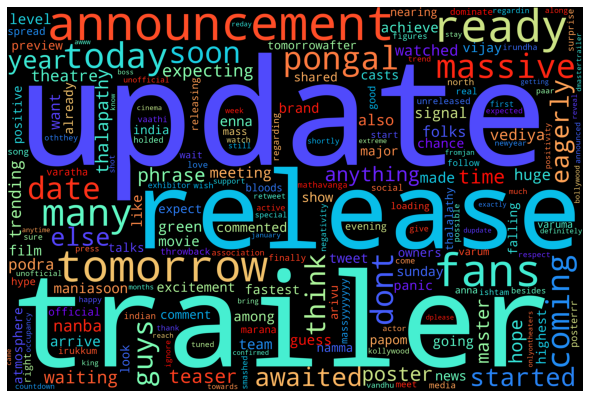

In [ ]:
from tqdm import tqdm
# generating a wordcloud for visual representation
string=''
for i,r in tqdm(df.iterrows()):
    string+=' '.join(r['tokens_no_stop'])+' '

# wordcloud = WordCloud(width = 800, height = 800, 
#                 background_color ='white', 
#                 stopwords = stop_words, 
#                 min_font_size = 10).generate(string) 
  
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords = stop_words).generate(string)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

wordcloud.to_file('./wordcloud.png')
df.to_pickle('./pre-processed-tweets.pkl')

#Sentiment Analysis

In [ ]:
df = pd.read_pickle('pre-processed-tweets.pkl')

In [ ]:
df.head()

,CreatedAt,tweets,User_ID,User_Name,tidy_tweets,tidy_tweet_tokens,tokens_no_stop
2,2020-12-28 14:09:50,b'@Aji_spartan \n\n@sharan14110326 \n\n@Vasant...,1.251350e+18,💘𝐉𝐞𝐧𝐢💘𝐈𝐜𝐞 𝐃𝐨𝐥𝐥♥🇱🇰,follow keep suppor,"[follow, keep, suppor]","[follow, keep, suppor]"
4,2020-12-28 14:09:46,"b""RT @ManokarVj: Teaser &amp; Trailer announce...",1.008243e+18,Bigil Ashok,teaser trailer announcement pics thalapathy vi...,"[teaser, trailer, announcement, pics, thalapat...","[teaser, trailer, announcement, pics, thalapat..."
6,2020-12-28 14:09:40,b'RT @dp_karthik09: Chances of #MasterTrailer ...,9.701324e+17,Saravana Pradeep,chances falling sunday papom,"[chances, falling, sunday, papom]","[chances, falling, sunday, papom]"
12,2020-12-28 14:09:24,b'RT @ActorVijayFP: #MasterTrailer Announcemen...,1.039062e+18,VIJAYAKUMAR,announcement with release date,"[announcement, with, release, date]","[announcement, release, date]"
14,2020-12-28 14:09:22,b'RT @FaijulVijay: Kollywood Finished....\xf0\...,4.605078e+09,Jithu hafiz,kollywood finished enext bollywood pongal,"[kollywood, finished, enext, bollywood, pongal]","[kollywood, finished, enext, bollywood, pongal]"


In [ ]:
def get_tweet_sentiment(tweet):
  ''' 
	Utility function to classify sentiment of passed tweet 
	using textblob's sentiment method 
	'''
	# create TextBlob object of passed tweet text 
  analysis = TextBlob(tweet)
  
  # print(analysis.sentiment)

	# set sentiment 
  if analysis.sentiment.polarity > 0:
    return 'positive', analysis.sentiment.polarity, analysis.sentiment.subjectivity

  elif analysis.sentiment.polarity == 0:
    return 'neutral', analysis.sentiment.polarity, analysis.sentiment.subjectivity
  else:
    return 'negative', analysis.sentiment.polarity, analysis.sentiment.subjectivity


In [ ]:
'''
calculating polarities for tweets on the given hashtag

link to output of the cell :
https://colab.research.google.com/drive/1B1KqIjwpTMgC8L1C0eooeUNscjkQXdua?authuser=1#scrollTo=KuhXEmtForV3&line=1&uniqifier=1

'''
from tqdm import tqdm
sentiments = []
polarities = []
for i,r in tqdm(df.iterrows()):
  temp = get_tweet_sentiment(r['tidy_tweets'])
  sentiments.append(temp[0])
  polarities.append(temp[1])

df['sentiment'] = sentiments
df['polarity'] = polarities
df.head()

"""
The below line was used to save the modified dataframe
Uncomment to do save the dataframe with polarities.
"""
# df['User_ID'] = df['User_ID'].astype('int64') 
# df.to_csv("./sentiments_and_polarities_with_pre_processed.csv", index=False)

In [ ]:
# getting unique users
user = df['User_ID'].unique()
print("Number of unique users in the sampled dataset",len(user))

In [ ]:
# Creating a dictionary which stores number of tweets of a user on "#MasterTrailer"
user_freq = dict(zip(user, [0]*len(user))) 
for i,r in df.iterrows():
  user_freq[r['User_ID']]+=1
#this shows how active a user was 

In [ ]:
'''
The below code was just used to save the users' active status.
Uncomment to do save the findings.
'''
# file = open("unique_users.txt", "w+")
# for i in user:
#   file.write(str(i))
#   file.write("\n")
# file.close()

# file = open("users_freq.txt", "w+")
# file.write(str(user_freq))
# file.close()

In [ ]:
# [negative, neutral, positive]
df = pd.read_csv('sentiments_and_polarities_with_pre_processed.csv')
sentiment_of_user=dict(zip(user, [0]*len(user))) 
for i,r in tqdm(df.iterrows()):
  polarity = r['polarity']
  if type(sentiment_of_user[r['User_ID']])==int:
    sentiment_of_user[r['User_ID']]=[0,0,0]
  if polarity>0:
    sentiment_of_user[r['User_ID']][2]+=1
  elif polarity==0.0:
    sentiment_of_user[r['User_ID']][1]+=1
  else:
    sentiment_of_user[r['User_ID']][0]+=1

'''
The below code is just to save our findings
Uncomment to do save the dictionary.
'''
# file = open("sentiments_of_users.txt", "w+")
# file.write(str(sentiment_of_user))
# file.close()

In [ ]:
req_list = list(sentiment_of_user.items())
req_list.sort(key=lambda x: x[0])

y1 = [i[1][0] for i in req_list] #negative 
y2 = [i[1][1] for i in req_list] #neutral
y3 = [i[1][2] for i in req_list] #positive

x1 = [i[0] for i in req_list] # users
x2 = [i[0] for i in req_list] # users
x3 = [i[0] for i in req_list] # users

plt.figure(figsize=(10,5))
plt.bar(list(range(len(req_list))),y1, label="Neg", width=5)

# plt.bar(left, height, tick_label = tick_label, 
#         width = 0.8, color = ['red', 'green']) 
  
plt.xlabel("User's Index in req_list")
plt.ylabel("# negative tweets by the user")

plt.legend()
# plt.savefig('plot_neg.png')
plt.show()

plt.figure(figsize=(10,5))
plt.bar(list(range(len(req_list))),y2, label="Neu", width = 5)
plt.xlabel("User's Index in req_list")
plt.ylabel("# neutral tweets by the user")

plt.legend()
# plt.savefig('plot_neu.png')
plt.show()

plt.figure(figsize=(10,5))
plt.bar(list(range(len(req_list))),y3, label="Pos")
plt.xlabel("User's index in the req_list")
plt.ylabel("# positive tweets by the user")

plt.legend()
# plt.savefig('plot_pos.png')
plt.show()


##Friends

In [ ]:
'''
To get the tweets of friends of the users on the "#MasterTrailer"
Uncomment below line
'''
# !python3 get_friends.py
# !python3 get_friends_tweets.py

In [ ]:
df_friends_tweets = pd.read_csv('friend_tweets.csv')
df_friends_tweets.head()

In [ ]:
from tqdm import tqdm
# df['sentiment'] = ""
# df['polarity'] = None
# df['sentiment'].apply(get_tweet_sentiment)
sentiments = []
polarities = []
subjectivities = []
for i,r in tqdm(df_friends_tweets.iterrows()):
  temp = get_tweet_sentiment(r['text'])
  sentiments.append(temp[0])
  polarities.append(temp[1])
  subjectivities.append(temp[2])
df_friends_tweets['sentiment'] = sentiments
df_friends_tweets['polarity'] = polarities
df_friends_tweets['subjectivity'] = subjectivities

df_friends_tweets.head()

In [ ]:
'''
user_friend_dict has (user_id, [polarity_sum, subjectivity_sum]) as (Key,Value) pair
polarity_sum is nothing but sum of the polarities of tweets retrieved of the friends of key (user_id)
subjectivity_sum is nothing but sum of the subjectivities of tweets retrieved of the friends of key (user_id)
'''

temp_friends = df_friends_tweets.groupby('user_id')
user_friend_dict = {}
for i,r in temp_friends:
  polarity = r['polarity'].sum()
  subjectivity = r['subjectivity'].sum()
  user_friend_dict[i]=[polarity, subjectivity]

user_friend_dict

In [ ]:
'''

'''
import matplotlib.pyplot as plt 

sentiment_of_user_without_count = {}

for i,r in df.groupby('User_ID'):
  polarity = r['polarity'].sum()
  sentiment_of_user_without_count[i]=polarity


common_users_list = [i[0] for i in list(sentiment_of_user.items()) if i[0] in list(user_friend_dict.keys())]
y1 = [sentiment_of_user_without_count[i] for i in common_users_list] #negative 
x1 = [i for i in common_users_list] # users

y2 = [user_friend_dict[i][0] for i in common_users_list]
plt.figure(figsize=(10,5))
plt.bar(list(range(len(common_users_list))),y1, label="users")
plt.bar(list(range(len(common_users_list))),y2, label="friends")
plt.xlabel("Users' indexes as in common_users_list")
plt.ylabel("Polarities' Sum of tweets ")
plt.xticks(list(range(len(common_users_list))),list(range(len(common_users_list))))
plt.legend()
# plt.savefig('plot_users_friends_polarities.png')
plt.show()


## Followers

In [ ]:
'''
To extract followers of users and their respective tweets with the hashtag "#MasterTrailer"
Uncomment the below lines
'''
# !python3 get_followers.py
# !python3 get_followers_tweets.py

In [ ]:
df_followers_tweets = pd.read_csv('follower_tweets.csv')

In [ ]:
from tqdm import tqdm
sentiments = []
polarities = []
subjectivities = []
for i,r in tqdm(df_followers_tweets.iterrows()):
  temp = get_tweet_sentiment(r['text'])
  sentiments.append(temp[0])
  polarities.append(temp[1])
  subjectivities.append(temp[2])
df_followers_tweets['sentiment'] = sentiments
df_followers_tweets['polarity'] = polarities
df_followers_tweets['subjectivity'] = subjectivities

In [ ]:
user_follower_dict = {}
for i,r in df_followers_tweets.groupby('user_id'):
  polarity = r['polarity'].sum()
  subjectivity = r['subjectivity'].sum()
  user_follower_dict[i]=[polarity, subjectivity]

user_follower_dict

In [ ]:
import matplotlib.pyplot as plt 

common_users_list = [i[0] for i in list(sentiment_of_user.items()) if i[0] in list(user_follower_dict.keys())]
y1 = [sentiment_of_user_without_count[i] for i in common_users_list] #negative 
x1 = [i for i in common_users_list] # users

y2 = [user_follower_dict[i][0] for i in common_users_list]

plt.figure(figsize=(20,5))
plt.plot(list(range(len(common_users_list))),y1, label="users")
plt.plot(list(range(len(common_users_list))),y2, label="followers")
plt.xlabel("Users' index as in common_users_list")
plt.ylabel("Polarities' Sum of tweets")
plt.xticks(list(range(len(common_users_list))),list(range(len(common_users_list))))
plt.legend()
# plt.savefig('plot_pos.png')
plt.show()
